In [1]:
import os
from glob import glob
import rasterio as rio
import numpy as np
from tqdm import tqdm,tqdm_notebook
from rasterio.plot import reshape_as_image,reshape_as_raster
import re
import pandas as pd
import json
import geopandas as gpd
from rasterio.mask import mask

import seaborn as sns
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from sklearn.cluster import MiniBatchKMeans
from rasterio.features import sieve
from rasterio.plot import reshape_as_image
from affine import Affine
from skimage.filters import threshold_multiotsu,threshold_otsu,threshold_yen,threshold_triangle,threshold_local,threshold_li

def strat_rand_sampling(file,outf,size,nodat=0,seed=None):
    #set seed for numpy random 
    np.random.seed(seed)
    
    data = []
    with rio.open(file) as src:
        
        #translate rows, cols to xy coordinates
        T0 = src.transform
        T1 = T0 * Affine.translation(0.5, 0.5)
        rc2xy = lambda r, c: T1 * (c, r) 

        img = src.read(1)
        strata = np.unique(img)[np.unique(img)!=nodat]
        
        #sample each stratum to a geopanda dataframe
        for stratum in strata: 
            
            rows,cols = np.where(img==stratum)
            idx = np.random.choice(np.arange(len(rows)), size, replace=False)
            stratified_samples = np.array([rc2xy(x, y) for x,y in zip(rows[idx],cols[idx]) ])
            x,y = stratified_samples[:,0],stratified_samples[:,1]
            gdf = gpd.GeoDataFrame(crs=str(src.crs), geometry=gpd.points_from_xy(x,y))
            gdf['class'] = stratum
            data.append(gdf)
    
    data_cat = pd.concat(data,ignore_index=True)
    data_cat.to_file(outf,driver="GeoJSON")
    print(f'Exported as: {outf}')
    
        
def compute_cluster(rws_rgb_img,k=4):
    rws_rgb_img = rws_rgb_img.astype(np.float32)/10000
    samples = reshape_as_image(rws_rgb_img).reshape(-1,rws_rgb_img.shape[0])
    kmeans_pred = MiniBatchKMeans(n_clusters=k+1, random_state=42,max_iter=10,batch_size=10000,reassignment_ratio=0).fit(samples)
    kmeans_pred_img = kmeans_pred.labels_.reshape(rws_rgb_img.shape[1], rws_rgb_img.shape[2]).astype(rio.uint16)
    return kmeans_pred_img

def compute_mnws(img,cluster_img,bands=['B2','B3','B4','B8a','B11','B12']):
    np.seterr(divide='ignore', invalid='ignore')
    
    band_pos = get_arr(bands)
    
    raw_img = img[band_pos]

    mnws = []
    
    max_i = np.argmax(np.unique(cluster_img,return_counts=True)[1])
    all_labels = list(range(0,cluster_img.max()+1))
    labels = list(set(all_labels)-set([all_labels[max_i]]))

    for label in labels:
        
        #calculate band stats
        region_img = np.where(cluster_img==label,raw_img,0)
        band_means = np.array(list(map(lambda x:np.mean(region_img[x][region_img[x]!=0],dtype=np.float32),
                                       range(len(band_pos))))).reshape(len(band_pos),-1)
        band_std = np.array(list(map(lambda x:np.std(region_img[x][region_img[x]!=0],dtype=np.float32),
                                     range(len(band_pos))))).reshape(len(band_pos),-1)
        
        #calculate nws 
        reshaped_raw_img = raw_img.reshape(len(band_pos),-1)
        nws = (((( abs(reshaped_raw_img-band_means) /band_std)**2).sum(0)/len(band_pos))**0.5).reshape(img.shape[1],img.shape[2])
        mnws.append(nws)
        
    mnws_img = np.array(mnws).min(0)

    return mnws_img

def multitemp_clmasks(target_img,reference_img):
    np.seterr(divide='ignore', invalid='ignore')
    
    #cloud shadow = 1 and thick cloud = 2
    db8a = target_img[get_arr('b8a')]-reference_img[get_arr('b8a')]
    db11 = target_img[get_arr('b11')]-reference_img[get_arr('b11')]
    db2 = target_img[get_arr('b2')]-reference_img[get_arr('b2')]
    db3 = target_img[get_arr('b3')]-reference_img[get_arr('b3')]
    db4 = target_img[get_arr('b4')]-reference_img[get_arr('b4')]

    ndvi = compute_index(target_img,'NDVI')
    
    cl_shadow = np.where( (db8a<-400) & ( db11<-400 ),1,0)
    cl_thick = np.where( ((db2 > 800) & (db3 >800) & (db4 >800)),2,0)
    forest_sh = np.where(ndvi>0.5,3,0)
       
    cl_masks = np.array([cl_shadow,cl_thick,forest_sh])
    cl_masks = np.amax(cl_masks,axis=0)
    
    return cl_masks
        
def wcf_mnws(mnws_files,invalid_files,upland_file,thr=3,dec=2):
    
    with rio.open(upland_file) as src_upland:
        upland_mask = src_upland.read(1)
    
        water_rws_detected = []
        invalid_pixels = []    

        for i in tqdm(range(len(mnws_files)),position=0, leave=True):
            mnws_file = mnws_files[i]
            cl_mask_file = invalid_files[i]

            with rio.open(mnws_file) as src_mnws,rio.open(cl_mask_file ) as src_mask:
                profile = src_mnws.profile.copy()
                mnws_img = src_mnws.read(1)
                mnws_img[np.isnan(mnws_img)]=9999

                cl_mask = src_mask.read(1)

                invalid = np.where(cl_mask==2,1,0)
                invalid_pixels.append(invalid)

                water_rws = np.where(mnws_img<=thr,1,0)

                water_rws = np.where( cl_mask>0,0,water_rws)
                water_rws_detected.append(water_rws)

        water_rws_detected_sum = np.where(upland_mask==1,0,np.array(water_rws_detected).sum(0))
        invalid_pixels_sum = np.array(invalid_pixels).sum(0)
        diff_invalid = len(mnws_files)-invalid_pixels_sum

        water_freq_img = np.true_divide(water_rws_detected_sum , diff_invalid, where=(diff_invalid!=0),dtype=np.float32)*12
        water_freq_img_r = np.round(water_freq_img,dec)

        return water_freq_img_r,water_rws_detected_sum,profile


def get_arr(bands):
    band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B10','B11','B12']
    if isinstance(bands,list):
        return [band_names.index(band.upper()) for band in bands]
    else:
        return band_names.index(bands.upper())
    
def compute_index(arr,name):
    np.seterr(divide='ignore', invalid='ignore')
    
    if name == 'MNDWI':
        b3= arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        index = (b3-b11)/(b3+b11)
        
    elif name == 'MNDWI2':
        b3= arr[get_arr('b3')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        index = (b3-b12)/(b3+b12)
        
    elif name == 'MNDVI':
        b5= arr[get_arr('b5')].astype(np.float32)
        b7= arr[get_arr('b7')].astype(np.float32)
        index = (b7-b5)/(b7+b5)
        
    elif name =='NDVI':
        b8a= arr[get_arr('b8a')].astype(np.float32)
        b4= arr[get_arr('b4')].astype(np.float32)
        index = (b8a-b4)/(b8a+b4)
        
    elif name =='MGRN':
        index = (arr[get_arr(['b3','b4','b8a'])].astype(np.float32)/10000).min(0)
    
    elif name =='AWEI_NSH':
        b3 = arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        b8a = arr[get_arr('b8a')].astype(np.float32)
        index = (4*(b3-b11)) -( (0.25*b8a) +(2.75*b12) )
        
    elif name =='AWEI_SH':
        b2 = arr[get_arr('b2')].astype(np.float32)
        b3 = arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        b8a = arr[get_arr('b8a')].astype(np.float32)
        index = b2+2.5*b3-1.5*(b8a+b11)-0.25*b12

    return index

def compute_wiw(arr):
    b8a = arr[get_arr('b8a')].astype(np.float32)/10000
    b12 = arr[get_arr('b12')].astype(np.float32)/10000
    return np.where( ((b8a<=0.1804)) & ((b12<=0.1131)), 1, 0)

def compute_rws(arr,index_type='MNDWI',method='otsu'):
    water_index = compute_index(arr,index_type)
    mgrn = compute_index(arr,'MGRN')
    
    if method == 'otsu':
        thr = threshold_otsu(water_index[water_index>=0])
    elif method == 'li':
        thr = threshold_li(water_index[water_index>=0],initial_guess=0.3)
    
    rws = np.where( (water_index>=thr) &((mgrn>0) & (mgrn<0.15)),1,0)
    rws_img = np.where(rws==1,arr,0)
    return rws_img,rws

def wd_count(mnws_files,invalid_files,upland_file,thr=3):
    
    wd = {}
   
    with rio.open(upland_file) as src_upland:
        upland_mask = src_upland.read(1)
    
        for i in tqdm(range(len(mnws_files)),position=0, leave=True):
            mnws_file = mnws_files[i]
            date = re.findall(r"(\d{8})", mnws_file)[0]
            cl_mask_file = invalid_files[i]

            with rio.open(mnws_file) as src_mnws,rio.open(cl_mask_file ) as src_mask:
                profile = src_mnws.profile.copy()
                mnws_img = src_mnws.read(1)
                mnws_img[np.isnan(mnws_img)]=9999

                cl_mask = src_mask.read(1)

                if thr=='otsu':
                    thr = threshold_otsu(mnws_img[(mnws_img<8)&(mnws_img>1)])

                water_rws = np.where( (mnws_img<=thr)&(upland_mask!=1),1,0)
                
                water_rws = np.where( (cl_mask==1) | (cl_mask==3),0,water_rws)

                wd[date] = np.count_nonzero(water_rws)
    df = pd.DataFrame(wd,index=[0]).T
    df.columns = ['pixel_count']
    return  df

def calc_acc(y_true,y_pred):
    
    observed = y_true.rename('Observed')
    classified = y_pred.rename('Classified')
    con_mat = pd.crosstab(classified,observed)
    
    row_sum = con_mat.sum(axis=1)
    col_sum = con_mat.sum(axis=0)
    omitted = np.setdiff1d(col_sum.index,row_sum.index)
    col_sum = col_sum.drop(omitted)
    
    ua = np.diag(con_mat)/row_sum
    pa = np.diag(con_mat)/col_sum
    f1 = (2 * pa*ua) /(pa+ua)
    
    acc_df = round(pd.DataFrame({'Label':col_sum.index,'PA':pa.values,'UA':ua.values,'F1-score':f1.values}),2).fillna(0)
    acc_df.set_index('Label',inplace=True)
    
    
    return acc_df,con_mat


def plot_acc(acc_df,con_mat,labels,oa_alt=None,fig_text=None):
    
    acc_df = acc_df.copy()
    con_mat = con_mat.copy()
    
    oa =np.diag(con_mat).sum()/con_mat.sum().sum()  

    sns.set(font_scale=1.6)
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': '0'})

    fig, axs = plt.subplots(1,2,figsize=(12,5))

    con_mat.columns = [f'{b}\n{a}' for a,b in zip(labels,con_mat.sum(0))]
    con_mat.index = [f'{a}\n{b}' for a,b in zip(labels,con_mat.sum(1))]
    
    con_mat_plot = sns.heatmap(con_mat,annot=True,cbar=False,ax=axs[0],cmap='Blues')
    axs[0].set_xlabel('Observed')
    axs[0].set_ylabel('Classified')
    for _, spine in con_mat_plot.spines.items(): 
        spine.set_visible(True)
    
    acc_df.index = labels
    sns.lineplot(data=acc_df,ax=axs[1],dashes=False,sort=False)
    sns.scatterplot(data = acc_df,ax=axs[1])
    plt.ylim(0.35, 1)
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Label')
    
    leg = axs[1].legend(acc_df.columns.tolist()+[f'OA: { "%.2f" % oa} ({oa_alt}*)'],loc='best')
    leg.get_lines()[-1].set_visible(False)
    axs[0].text(-0.90,1.05,fig_text,horizontalalignment='center',verticalalignment='center',transform=axs[1].transAxes)


In [ ]:
%%time

#data mask computation
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')

nodata_list = []

for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]

    with rio.open(file) as src:
        profile = src.profile.copy()

        img = src.read()
        img = np.where(img<0,0,img)
        
        nodata_img_sum = np.where(img==src.nodata,1,0).sum(0).astype(rio.uint8)
        nodata_img_mask = np.where(nodata_img_sum!=0,1,0).astype(rio.uint8)
        nodata_list.append(nodata_img_mask)
        
#inverse nodata mask        
nodata_list_sum = np.array(nodata_list).sum(0).astype(rio.uint8)
data_list_mask = np.where(nodata_list_sum!=0,0,1).astype(rio.uint8)

#sieve data to ommit isolated pixels
data_list_mask_sieved = sieve(data_list_mask,100)

outf =  f'{os.path.abspath("..")}results/data_mask.tif'

profile.update(nodata=0,count=1,dtype=data_list_mask_sieved.dtype)
with rio.open(outf,'w',**profile) as dst:
    dst.write_band(1,data_list_mask_sieved)


In [ ]:
%%time

#cloud masks computation monthly best reference image

#mosaics
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
dates = [re.findall(r"(\d{8})", file)[0] for file in mosaics]

#reference mosaics
ref_dates = [20170119,20170119,20170327,20170327,20170615,20170615,20170720,20170824,20171008,20171008,20171117,20171117]
ref_mosaics = [mos for date in ref_dates for mos in mosaics if str(date) in mos ]
months = pd.to_datetime(dates).strftime('%Y%m').unique().tolist()
ref_dict = dict(zip(months,ref_mosaics))

data_mask_file = f'{os.path.abspath("..")}results/data_mask.tif'

with rio.open(data_mask_file) as src_data_mask:
    data_mask = src_data_mask.read()

    for i in tqdm(range(len(mosaics)),position=0, leave=True):
        file = mosaics[i]
        outf = f'{ os.path.abspath("..") }results/invalid_masks_min400_ndvi03/invalid_{dates[i]}.tif'

        ref_file = [ref_dict[key] for key in list(ref_dict.keys()) if key in file][0]

        with rio.open(file) as src,rio.open(ref_file) as src_ref:
            profile = src.profile.copy()
            src_img = np.where(src.read()<0,0,src.read()).astype(rio.int16)
            src_img = np.where(data_mask==1,src_img ,src.nodata).astype(rio.int16)
            
            src_ref_img = np.where(src_ref.read()<0,0,src_ref.read()).astype(rio.int16)
            src_ref_img = np.where(data_mask==1,src_ref_img ,src.nodata).astype(rio.int16)
            
            _,rws = compute_rws(src_img,'MNDWI','otsu')
            cl_masks = multitemp_clmasks(src_img,src_ref_img).astype(rio.int8)
            cl_masks = np.where((src_img[0]!=src.nodata)&(rws!=1),cl_masks,0).astype(rio.int8)
            
            #write to new geotiff
            profile.update({'dtype':cl_masks.dtype,'nodata':0,'count':1})
            with rio.open(outf ,'w',**profile) as dst:
                dst.write_band(1, cl_masks)
                dst.set_band_description(1, f'invalid_{dates[i]}')

In [ ]:
%%time

#mnws computation
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')

data_mask_file = f'{os.path.abspath("..")}results/misc/data_mask.tif'

with rio.open(data_mask_file) as src_data_mask:

    data_mask = src_data_mask.read()

    for i in tqdm(range(len(mosaics)),position=0, leave=True):
        file = mosaics[i]

        outf = f'{os.path.abspath("..")}results/rws_mnws_mndwi_otsu/{os.path.basename(file)}'.replace('mosaic','rws_mnws')

        with rio.open(file) as src:
            profile = src.profile.copy()

            img = src.read()
            img = np.where(img<0,0,img)
            img = np.where(data_mask==1,img,src.nodata).astype(rio.int16)

            #compute RWS region
            rws_img,_ = compute_rws(img,'MNDWI','otsu')

            #cluster and compute MNWS
            cluster_img = compute_cluster(rws_img[get_arr(['B2','B3','B4'])],8) 
            
            mnws = compute_mnws(img,cluster_img,bands=['B2','B3','B4','B8A','B11','B12'])
            mnws = np.where(img[0]==src.nodata,src.nodata,mnws).astype(rio.float32)

            profile.update(nodata=src.nodata,count=1,dtype=mnws.dtype)
            with rio.open(outf,'w',**profile) as dst:
                dst.write_band(1,mnws)

            


In [ ]:
%%time
# #compute water coverage frequency map
mnws_files = glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/rws*.tif")
cl_mask_files = glob(f"{os.path.abspath('..')}results/invalid_masks_min400_ndvi05/invalid*.tif")
upland_file = f"{os.path.abspath('..')}results/misc/upland_gte30.tif"

wf_rws,water_sum,profile = wcf_mnws(mnws_files,cl_mask_files,upland_file,thr=3,dec=2)

#reclassify to water body types
data_mask_file = f'{os.path.abspath("..")}results/misc/data_mask.tif'

with rio.open(data_mask_file) as src_data_mask:
    
    #used to assign non-water pixels (class value = 0)
    data_mask = src_data_mask.read(1)
    
    #reclassification of WF image
    dwm = wf_rws.copy()
    wetland = ((dwm >0)&(dwm <3))*2     #wetland
    sw = ((dwm >=3)&(dwm <=9))*3        #seasonal water
    pw = (dwm>9)*4                      #permanent water
    
    dwm_sum = np.array([wetland,sw,pw]).sum(0)
    dwm_out = np.where(dwm_sum>0,dwm_sum,data_mask).astype(rio.uint8)

    #sieve data
    dwm_out_sieved = sieve(dwm_out,size=30,connectivity=8)
    
    #export rasters
    out_wf = f"{os.path.abspath('..')}results/wf_rws.tif"
    profile.update({'dtype':wf_rws.dtype,'nodata':0,'count':1})
    with rio.open(out_wf,'w',**profile) as dst: dst.write_band(1,wf_rws)

    out_water_sum = f"{os.path.abspath('..')}results/watersum.tif"
    profile.update({'dtype':rio.uint8,'nodata':0,'count':1})
    with rio.open(out_water_sum,'w',**profile) as dst: dst.write_band(1,water_sum.astype(rio.uint8))

    out_dwm = f"{os.path.abspath('..')}results/dwm.tif"
    profile.update({'dtype':rio.uint8,'nodata':0,'count':1})
    with rio.open(out_dwm ,'w',**profile) as dst: dst.write_band(1,dwm_out_sieved)


In [ ]:
dwm_file =  f"{os.path.abspath('..')}results/dwm.tif"
jrc_file= f"{os.path.abspath('..')}ancillary_data/YearlyHistory_2017_masked.tif"
sample_points = gpd.read_file(glob(f"./data/sample/accuracy_assesment/*classified.geojson")[0])
sample_points = sample_points[sample_points.rating=='high']
with rio.open(dwm_file) as src_dwm,rio.open(jrc_file) as src_jrc:
    coords = list((zip(sample_points['geometry'].centroid.x,sample_points['geometry'].centroid.y)))
    sample_points['dwm_label'] = [val[0] for val in src_dwm.sample(coords)]
    sample_points['gsw_label'] = [val[0]+1 for val in src_jrc.sample(coords)]

# sample_points = sample_points[sample_points['rating']=='high']
# S2-DWM all classes
acc_df,con_mat = calc_acc(sample_points['true_label'],sample_points['dwm_label'])
plot_acc(acc_df,con_mat,sample_points['true_name'].unique(),0.73,'(a.) S2-DWM four classes')

#s2-DWM nw, sw (+wetland) and pw
acc_df,con_mat = calc_acc(sample_points['true_label'].replace(2,3),sample_points['dwm_label'].replace(2,3))
plot_acc(acc_df,con_mat,sample_points['true_name'].unique()[[0,2,3]],0.85,'(b.) S2-DWM three classes')

#JRC-GSW-S nw, wl (original nw), sw and nw
acc_df,con_mat = calc_acc(sample_points['true_label'],sample_points['gsw_label'])
plot_acc(acc_df,con_mat,sample_points['true_name'].unique(),0.82,'(c.) JRC-GSW-S four classes')

#JRC-GSW-S nw (original nw and all not pixels not classified), sw and pw
acc_df,con_mat = calc_acc(sample_points['true_label'].replace(2,1),sample_points['gsw_label'].replace(2,1))
plot_acc(acc_df,con_mat,sample_points['true_name'].unique()[[0,2,3]],0.85,'(d.) JRC-GSW-S three classes')

In [268]:
#lat lon surface water area

dwm_file =  f"{os.path.abspath('..')}results/dwm.tif"
jrc_file= f"{os.path.abspath('..')}ancillary_data/YearlyHistory_2017_masked.tif"

with rio.open(dwm_file) as src_dwm, rio.open(jrc_file) as src_jrc:
    water_maps = np.array([src_dwm.read(1) ,src_jrc.read(1)])
    height = water_maps.shape[1]
    width = water_maps.shape[2]
    
    steps = 10
    
    water_lat = {}
    lat_steps = range(0,height,steps)
    for lat in lat_steps:
        water_lat[f"lat_dwm_{lat}"] = dwm_jrc[0,lat,:]
        water_lat[f"lat_jrc_{lat}"] = dwm_jrc[1,lat,:]
    water_lat_df = pd.DataFrame(water_lat)
    water_lat_sum_dwm = pd.DataFrame(((water_lat_df.filter(regex=("dwm"))==4)*1).sum(0)/100,columns=['Lat. S2-DWM (Pw)']).reset_index(drop=True)
    water_lat_sum_jrc = pd.DataFrame(((water_lat_df.filter(regex=("jrc"))==3)*1).sum(0)/100,columns=['Lat. JRC-GSW-S (Pw)']).reset_index(drop=True)
    water_lat_sums_pw = pd.concat([water_lat_sum_dwm,water_lat_sum_jrc],1)
    water_lat_sums_pw.index = np.array(lat_steps)/100
    
    water_lon = {}
    lon_steps = range(0,width,steps)
    for lon in lon_steps:
        water_lon[f"lon_dwm_{lon}"] = dwm_jrc[0,:,lon]
        water_lon[f"lon_jrc_{lon}"] = dwm_jrc[1,:,lon]
    water_lon_df = pd.DataFrame(water_lon)
    water_lon_sum_dwm = pd.DataFrame(((water_lon_df.filter(regex=("dwm"))==4)*1).sum(0)/100,columns=['Lon. S2-DWM (Pw)']).reset_index(drop=True)
    water_lon_sum_jrc = pd.DataFrame(((water_lon_df.filter(regex=("jrc"))==3)*1).sum(0)/100,columns=['Lon. JRC-GSW-S (Pw)']).reset_index(drop=True)
    water_lon_sums_pw = pd.concat([water_lon_sum_dwm,water_lon_sum_jrc],1)
    water_lon_sums_pw.index = np.array(lon_steps)/100
    
    water_lat = {}
    lat_steps = range(0,height,steps)
    for lat in lat_steps:
        water_lat[f"lat_dwm_{lat}"] = dwm_jrc[0,lat,:]
        water_lat[f"lat_jrc_{lat}"] = dwm_jrc[1,lat,:]
    water_lat_df = pd.DataFrame(water_lat)
    water_lat_sum_dwm = pd.DataFrame(((water_lat_df.filter(regex=("dwm"))==3)*1).sum(0)/100,columns=['Lat. S2-DWM (Sw)']).reset_index(drop=True)
    water_lat_sum_dwm_wl = pd.DataFrame(((water_lat_df.filter(regex=("dwm")).isin([2,3])*1).sum(0)/100),columns=['Lat. S2-DWM (Sw + Wl)']).reset_index(drop=True)
    water_lat_sum_jrc = pd.DataFrame(((water_lat_df.filter(regex=("jrc"))==2)*1).sum(0)/100,columns=['Lat. JRC-GSW-S (Sw)']).reset_index(drop=True)
    water_lat_sums_sw = pd.concat([water_lat_sum_dwm,water_lat_sum_dwm_wl,water_lat_sum_jrc],1)
    water_lat_sums_sw.index = np.array(lat_steps)/100
    
    water_lon = {}
    lon_steps = range(0,width,steps)
    for lon in lon_steps:
        water_lon[f"lon_dwm_{lon}"] = dwm_jrc[0,:,lon]
        water_lon[f"lon_jrc_{lon}"] = dwm_jrc[1,:,lon]
    water_lon_df = pd.DataFrame(water_lon)
    water_lon_sum_dwm = pd.DataFrame(((water_lon_df.filter(regex=("dwm"))==3)*1).sum(0)/100,columns=['Lon. S2-DWM (Sw)']).reset_index(drop=True)
    water_lon_sum_dwm_wl = pd.DataFrame(((water_lon_df.filter(regex=("dwm")).isin([2,3])*1).sum(0)/100),columns=['Lon. S2-DWM (Sw + Wl)']).reset_index(drop=True)
    water_lon_sum_jrc = pd.DataFrame(((water_lon_df.filter(regex=("jrc"))==2)*1).sum(0)/100,columns=['Lon. JRC-GSW-S (Sw)']).reset_index(drop=True)
    water_lon_sums_sw = pd.concat([water_lon_sum_dwm,water_lon_sum_dwm_wl,water_lon_sum_jrc],1)
    water_lon_sums_sw.index = np.array(lon_steps)/100
    


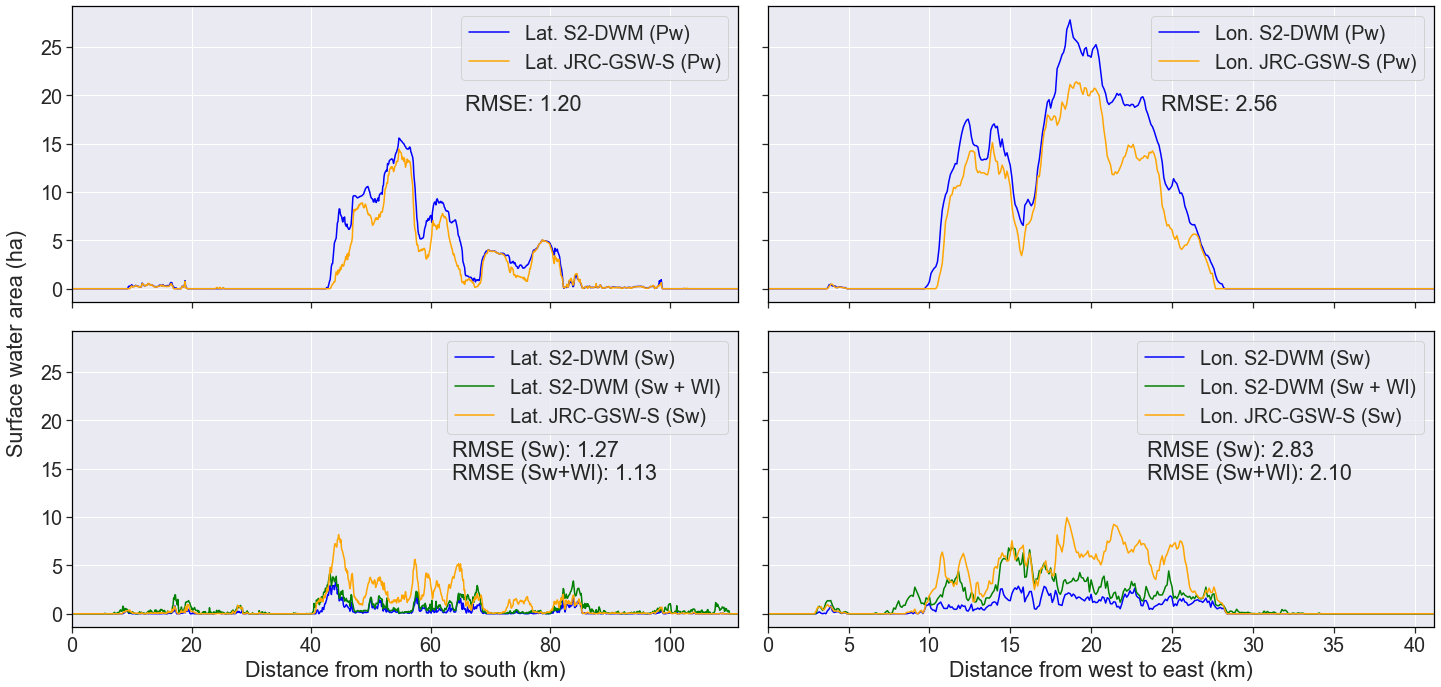

In [655]:
sns.set(font_scale=1.8)
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
fig, axs = plt.subplots(2,2,figsize=(20,10),sharey=True)
axs=axs.ravel()
sns.lineplot(data=water_lat_sums_pw,dashes=False,ax=axs[0],palette=['blue','orange'])
sns.lineplot(data=water_lon_sums_pw,dashes=False,ax=axs[1],palette=['blue','orange'])
sns.lineplot(data=water_lat_sums_sw,dashes=False,ax=axs[2],palette=['blue','green','orange'])
sns.lineplot(data=water_lon_sums_sw,dashes=False,ax=axs[3],palette=['blue','green','orange'])
axs[2].set_xlabel('Distance from north to south (km)')
axs[3].set_xlabel('Distance from west to east (km)')
fig.text(0, 0.5, 'Surface water area (ha)', ha='center', va='center', rotation='vertical')

for i in range(len(axs)):
    axs[i].margins(x=0)
    if i<2:
        axs[i].set_xticklabels([])
        
rmse_lat_pw = "%.2f" % np.sqrt(water_lat_sums_pw.iloc[:,1].sub(water_lat_sums_pw.iloc[:,0]).pow(2).mean())
axs[0].text(0.59,0.65, f"RMSE: {rmse_lat_pw}", ha="left", transform=axs[0].transAxes)

rmse_lon_pw ="%.2f" % np.sqrt(water_lon_sums_pw.iloc[:,1].sub(water_lon_sums_pw.iloc[:,0]).pow(2).mean())
axs[1].text(0.59,0.65, f"RMSE: {rmse_lon_pw}", ha="left", transform=axs[1].transAxes)

rmse_lat_sw = "%.2f" % np.sqrt(water_lat_sums_sw.iloc[:,2].sub(water_lat_sums_sw.iloc[:,0]).pow(2).mean())
rmse_lat_sw_wl = "%.2f" % np.sqrt(water_lat_sums_sw.iloc[:,2].sub(water_lat_sums_sw.iloc[:,1]).pow(2).mean())
axs[2].text(0.57,0.5, f"RMSE (Sw): {rmse_lat_sw}\nRMSE (Sw+Wl): {rmse_lat_sw_wl}", ha="left", transform=axs[2].transAxes)

rmse_lon_sw ="%.2f" % np.sqrt(water_lon_sums_sw.iloc[:,2].sub(water_lon_sums_sw.iloc[:,0]).pow(2).mean())
rmse_lon_sw_wl ="%.2f" % np.sqrt(water_lon_sums_sw.iloc[:,2].sub(water_lon_sums_sw.iloc[:,1]).pow(2).mean())
axs[3].text(0.57,0.5, f"RMSE (Sw): {rmse_lon_sw}\nRMSE (Sw+Wl): {rmse_lon_sw_wl}", ha="left", transform=axs[3].transAxes)

plt.tight_layout()


In [ ]:
#time-series analysis

dwm_file = f"{os.path.abspath('..')}results/dwm.tif"
mnws_files = glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/rws*.tif")
cl_mask_files = glob(f"{os.path.abspath('..')}results/invalid_masks_min400_ndvi05/invalid*.tif")
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
dates = [re.findall(r"(\d{8})", file)[0] for file in mosaics]

wetland_file = "./data/boundaries/high_vegetated.geojson"
wetland_geo = gpd.read_file(wetland_file)

with rio.open(dwm_file) as src_dwm:
    
    dwm,_ = mask(src_dwm, wetland_geo.geometry, crop=True)
    dwm = np.where(dwm==2,3,dwm)[0]
    
    data = []
    
    for i in tqdm(range(len(mosaics)),position=0, leave=True):

        with rio.open(mosaics[i]) as src, rio.open(mnws_files[i]) as src_mnws,rio.open(cl_mask_files[i]) as src_clm:

            img,_ = mask(src, wetland_geo.geometry, crop=True)
            clm,_ = mask(src_clm, wetland_geo.geometry, crop=True)
            mnws,_ = mask(src_mnws, wetland_geo.geometry, crop=True)
            
            img = np.where(img<0,0,img)
            ndvi = compute_index(img,'NDVI')
            mndwi = compute_index(img,'MNDWI')
            
            wi_arr = np.array([ndvi,mndwi,mnws[0]])
            wi_arr = np.where(clm>0,9999,wi_arr)
            
            values = []
            for i in [1,3,4]:
                val_arr = np.where(wi_arr[:,dwm==i]!=9999,wi_arr[:,dwm==i],np.nan)
                values += np.nanmedian(val_arr,1).tolist()
            data.append(values)
    df = pd.DataFrame(np.array(data))
    df.columns = ['NDVI_NW','MNDWI_NW','MNWS_NW','NDVI_SW','MNDWI_SW','MNWS_SW','NDVI_PW','MNDWI_PW','MNWS_PW']
    df = df.set_index(pd.to_datetime(dates))
    df.to_csv('./data/dwm_median_values_aoi.csv')

In [ ]:
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})

df = pd.read_csv('./data/dwm_median_values_aoi.csv',index_col=[0])
df.columns = ['NDVI (Nw)','MNDWI (Nw)','MNWS (Nw)','NDVI (Sw)','MNDWI (Sw)','MNWS (Sw)','NDVI (Pw)','MNDWI (Pw)','MNWS (Pw)']
df.index = pd.to_datetime(df.index)
df = df.resample('D').interpolate(method='linear')
df.index = df.index.strftime('%d-%b')

fig, axs = plt.subplots(3,2,figsize=(15,10),sharex=True)
axs = axs.ravel()

colors=['green','blue']
for i,d in enumerate(df.iloc[:,:2].columns):
    axs[0].plot(df.iloc[:,:2][d],color=colors[i])
axs[1].plot(df.iloc[:,2:3],color='red')
axs[1].axhline(3, 8,0,ls='--',color='black',lw=2)
axs[0].legend(['NDVI','MNDWI'])
axs[1].legend(['MNWS']);

for i,d in enumerate(df.iloc[:,3:5].columns):
    axs[2].plot(df.iloc[:,3:5][d],color=colors[i])
axs[3].plot(df.iloc[:,5:6],color='red')
axs[3].axhline(3, 8,0,ls='--',color='black',lw=2)


for i,d in enumerate(df.iloc[:,6:8].columns):
    axs[4].plot(df.iloc[:,6:8][d],color=colors[i])

axs[5].plot(df.iloc[:,8:],color='red')
axs[5].axhline(3, 8,0,ls='--',color='black',lw=2)



fig.text(0.01, 0.5, 'Value', ha='center', va='center', rotation='vertical')

axs[0].text(0.05,1.1,'(a.) Non-water',horizontalalignment='center',verticalalignment='center',transform=axs[0].transAxes)
axs[2].text(0.05,1.1,'(b.) Seasonal water',horizontalalignment='center',verticalalignment='center',transform=axs[2].transAxes)
axs[4].text(0.05,1.1,'(c.) Permanent water',horizontalalignment='center',verticalalignment='center',transform=axs[4].transAxes)

for ax in axs:
    ax.margins(x=0)

    ax.xaxis.set_ticks(np.arange(0, len(df),31))
    ax.set_xticklabels(df.index[::31].str.split('-').str[-1])
    ax.axvline(np.where(df.index=='25-Feb')[0][0],0,.05,ls='--',color='blue',lw=5)
    ax.axvline(np.where(df.index=='19-May')[0][0],0,.05,ls='--',color='blue',lw=5)
    
plt.tight_layout();

In [ ]:
sns.set(font_scale=1.4)
data= []
for c in df.columns:
    summary = round(df[c].describe(),1)
    summary['var'] = df[c].var()
    summary['median'] = df[c].median()
    data.append(summary)
data_df = pd.concat(data,1).T[['std','var','min','median','max']].T
sns.heatmap(data_df.T,annot=True,cbar=False,cmap='viridis');

In [ ]:
rain_df.sort_values('mm',ascending=False)

In [ ]:
def strat_rand_sampling(file,size,vstride_nr,nodat=0,seed=None):
    #set seed for numpy random 
    np.random.seed(seed)
    
    data = []
    with rio.open(file) as src:
        
        #translate rows, cols to xy coordinates
        T0 = src.transform
        T1 = T0 * Affine.translation(0.5, 0.5)
        rc2xy = lambda r, c: T1 * (c, r) 

        img = src.read(1)
        profile = src.profile.copy()
        block_img = img.copy()
        
        vstride = int(block_img.shape[0]/vstride_nr)
        
        for i in range(0,block_img.shape[0],vstride):
            random_label = int((i+vstride)/100)
            if i+vstride<block_img.shape[0]:
                block_img[i:i+vstride,:][block_img[i:i+vstride,:]>=0] = random_label
            else:
                block_img[i:,:][block_img[i:,:]>=0] = random_label
            
        stack_img = np.where(img>0,block_img,nodat).astype(rio.uint16)
        
        strata = np.unique(stack_img)[np.unique(stack_img)!=nodat]
        classes = np.unique(img)[np.unique(img)!=nodat]
        
        for grid in strata: 
            for c in classes:
                rows,cols = np.where((img==c)&(stack_img==grid))
        
                if len(rows)!=0:
                    idx = np.random.choice(range(len(cols)), size, replace=False)
                    stratified_samples = np.array([rc2xy(x, y) for x,y in zip(rows[idx],cols[idx]) ])
                    x,y = stratified_samples[:,0],stratified_samples[:,1]
                    gdf = gpd.GeoDataFrame(crs=str(src.crs), geometry=gpd.points_from_xy(x,y))
                    gdf['class'] = c
                    data.append(gdf)
        
        profile.update(nodata=0,dtype=stack_img.dtype)
        data_cat = pd.concat(data,ignore_index=True)
        return data_cat,stack_img.astype(rio.uint8),profile



In [ ]:
#create stratified random samples
file = glob(f'{os.path.abspath("..")}results/dwm*.tif')[0]

seed = 42

gdf,block_img,block_profile = strat_rand_sampling(file=file,size=13,vstride_nr = 4,nodat=0,seed=seed)


print(gdf.groupby('class').count())

#drop class with sample points larger than 50
# indices2drop = gdf[gdf['class']==1].sample(n=5,random_state = seed).index
# gdf = gdf.drop(indices2drop).reset_index(drop=True)

#add class description
gdf['desc'] = None
for c_code,c_desc in zip(gdf['class'].unique(),['Nw','Wl','Sw','Pw']):
    gdf.loc[gdf[gdf['class']==c_code].index,'desc'] = c_desc
    
print(gdf.groupby('class').count())

#xport sample points
gdf_file = './data//sample/stratified_random_52samples_segmented.geojson'
gdf.to_file(gdf_file,driver="GeoJSON")

#xport image block
with rio.open('./data//sample/blocks.tif','w',**profile) as dst:
    dst.write_band(1,block_img)

In [ ]:
file = glob(f'{os.path.abspath("..")}results/dwm*.tif')[0]
file_jrc = glob(f'{os.path.abspath("..")}ancillary_data/YearlyHistory_2017_masked.tif')[0]

data_mask_file = f'{os.path.abspath("..")}results/misc/data_mask.tif'

with rio.open(file) as src, rio.open(file_jrc) as src_jrc,rio.open(data_mask_file) as src_datamask:
    s2_img = src.read()
    jrc_img = src_jrc.read()
    datamask_img = src_datamask.read()
    jrc_img = np.where(datamask_img==1,jrc_img,9999)
    
    s2_count = pd.DataFrame(np.unique(s2_img[s2_img!=0],return_counts=True)[1]).T
    jrc_count = pd.DataFrame(np.unique(jrc_img[jrc_img!=9999],return_counts=True)[1]).T
    count_df = pd.concat([s2_count,jrc_count],0).reset_index(drop=True)*0.01
    count_df.columns = ['Non-water','Wetland','Seasonal water','Permanent water']
    count_df.index = ['S2-DWM','JRC-GSW-S']
count_df

In [ ]:
def mnws_boxplot(data):
    plt.figure(figsize=(10,5))
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
    flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')
    colors=['blue','orange','brown','yellow','green','purple','black']
    sns.boxplot(data=data,flierprops=flierprops,whis=[5, 95],orient='h',palette=colors,linewidth=1)
    plt.xlabel('MNWS',fontsize=16)
    plt.xticks(range(0, int(data.max().max()), 5))
#     plt.axvline(3, 8,0,ls='--',color='black',lw=2)
    plt.show()

def plot_spectral(band_data):
    sns.set(font_scale=1.5)
    colors=['blue','orange','brown','yellow','green','purple','red','black']
    lo_bound = band_data.loc['mean'].set_index('lc').T[['Water','Cloud shadow']]-band_data.loc['std'].set_index('lc').T[['Water','Cloud shadow']]
    hi_bound = band_data.loc['mean'].set_index('lc').T[['Water','Cloud shadow']]+band_data.loc['std'].set_index('lc').T[['Water','Cloud shadow']]
    plt.figure(figsize=(15,10))
    lines  = sns.lineplot(data=band_data.loc['mean'].set_index('lc').T,dashes=False,sort=False,palette=colors)
    lines.lines[0].set_linestyle("--")
    plt.ylabel('Surface Reflectance')
    plt.fill_between(band_names,lo_bound['Water'], hi_bound['Water'], alpha=.3)
    plt.fill_between(band_names,lo_bound['Cloud shadow'], hi_bound['Cloud shadow'], alpha=.3,color=colors[-1])
    plt.tight_layout()

In [ ]:
long_names = ['Water','Settlement','Dark soil',' Bright soil','Vegetation','Agriculture','Cloud','Cloud shadow']
labels = dict(zip(list(range(1,len(long_names)+1)),long_names))

sample_files = glob('./data/sample/sample*.geojson')
dates = list(map(lambda x:re.findall(r"(\d{8})", x)[0],sample_files))
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
mosaics = [img for date in dates for img in mosaics if date in img]

bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
nm = ['490','560','665','705','750','783','842','865','1910','2190']
band_names = [f'{a}\n{b} nm' for a,b in zip(bands,nm)]


all_band_data = []
all_mnws_data = []
for f in sample_files:
    date = re.findall(r"(\d{8})", f)[0]

    gdf = gpd.read_file(f)
    gdf = gdf.sort_values('code')
    geom_code = list((zip(gdf ['geometry'].tolist(), gdf['code'].tolist() )))
    
    fmnws = f'{os.path.abspath("..")}results/rws_mnws_mndwi_otsu/rws_mnws_{date}.tif'
    fmos = f'{os.path.abspath("..")}images/mosaic_{date}.tif'
        
    with rio.open(fmos) as src, rio.open(fmnws) as src_mnws:
    
        img = src.read()
        img = np.where(img<0,0,img)
        img = img[get_arr(bands)]
        img_mnws = src_mnws.read()
        sample_mask = rasterize(shapes=geom_code, out_shape=src.shape, transform=src.transform)
        
        #mnws stats
        mnws_data = pd.concat([pd.DataFrame(img_mnws[:,sample_mask==code]).T for code in gdf['code'].unique()],axis=1)
        mnws_data.columns = list(labels.values())
        all_mnws_data.append(mnws_data)
        
        band_data = []
        for code in gdf['code'].unique():
            band_df = pd.DataFrame(img[:,sample_mask==code]).T.describe().loc[['mean','std']]/10000
            band_df.columns = band_names
            band_df['lc'] = labels[code]
            band_data.append(band_df)
            
        band_data = pd.concat(band_data)
        all_band_data.append(band_data)

In [ ]:
mnws_boxplot(pd.concat(all_mnws_data).reset_index(drop=True).drop('Cloud',1))

In [ ]:
all_agg_mean = pd.concat(all_band_data).loc['mean'].groupby('lc').mean().T[list(labels.values())]
all_agg_std = pd.concat(all_band_data).loc['std'].groupby('lc').mean().T[list(labels.values())]
lo_bound = all_agg_mean[['Water','Cloud shadow']]-all_agg_std[['Water','Cloud shadow']]
hi_bound = all_agg_mean[['Water','Cloud shadow']]+all_agg_std[['Water','Cloud shadow']]

sns.set(font_scale=2)
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
plt.figure(figsize=(15,10))
colors=['blue','orange','brown','yellow','green','purple','red','black']
lines = sns.lineplot(data=all_agg_mean,dashes=False,sort=False,palette=colors,legend=False)
lines.lines[0].set_linestyle("--")
plt.legend(all_agg_mean.columns)
plt.ylabel('Surface Reflectance')
plt.fill_between(band_names,lo_bound['Water'], hi_bound['Water'], alpha=.3)
plt.fill_between(band_names,lo_bound['Cloud shadow'], hi_bound['Cloud shadow'], alpha=.3,color=colors[-1])
plt.margins(x=0)
plt.tight_layout()

In [ ]:
%%time

# MNWS and band stats example 25 Feb 2017
gdf = gpd.read_file(glob('./data/sample/sample*.geojson')[0])

long_names = ['Water','Settlement','Dark soil',' Bright soil','Vegetation','Agriculture','Cloud','Cloud shadow']

labels = dict(zip(gdf ['code'].unique(),long_names))
geom_code = list((zip(gdf ['geometry'].tolist(), gdf ['code'].tolist() )))

mosaic = [f for f in glob(f'{os.path.abspath("..")}images/*.tif') if '20170225' in f][0]
mnws = [f for f in glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/*.tif") if '20170225' in f][0]

bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
nm = ['490','560','665','705','750','783','842','865','1910','2190']
band_names = [f'{a}\n{b} nm' for a,b in zip(bands,nm)]

with rio.open(mosaic) as src,rio.open(mnws) as src_mnws:
    
    img = src.read()
    img = np.where(img<0,0,img)
    img = img[get_arr(bands)]
    img_mnws = src_mnws.read()
    
    sample_mask = rasterize(shapes=geom_code, out_shape=src.shape, transform=src.transform)
    labels.pop(7)
    
    #band stats
    band_data = pd.concat([pd.DataFrame(img[:,sample_mask==code].mean(1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data.columns = band_names
    band_data_std = pd.concat([pd.DataFrame(img[:,sample_mask==code].std(1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data_std.columns = band_names
    
    #mnws stats
    mnws_data = pd.concat([pd.DataFrame(img_mnws[:,sample_mask==code]).T for code in list(labels.keys())],axis=1)
    mnws_data.columns = list(labels.values())

    #mnws stats
    img_mndwi = compute_index(img,'MNDWI')
    mndwi_data = pd.concat([pd.DataFrame(img_mndwi[sample_mask==code]) for code in list(labels.keys())],axis=1)
    mndwi_data.columns = list(labels.values())


In [ ]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')
colors = ['blue','orange','brown','yellow','green','purple','black']

sns.boxplot(data=mndwi_data.dropna(),order=mndwi_data.columns,flierprops=flierprops,whis=[5, 95],orient='h',linewidth=1,palette=colors)
plt.xlabel('MNDWI value',fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')
colors = ['blue','orange','brown','yellow','green','purple','black']

sns.boxplot(data=mnws_data.dropna(),order=mnws_data.columns,flierprops=flierprops,whis=[5, 95],orient='h',linewidth=1,palette=colors)
plt.xlabel('MNWS value',fontsize=16)
plt.xticks(range(0, int(mnws_data.max().max()+5), 3))
plt.axvline(3, 8,0,ls='--',color='black',lw=2)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')
colors = ['blue','orange','brown','yellow','green','purple','black']

sns.boxplot(data=mnws_data,order=mnws_data.columns,flierprops=flierprops,whis=[5, 95],orient='h',linewidth=1,palette=colors)
plt.xlabel('MNDWI value',fontsize=16)
plt.xticks(range(0, int(mnws_data.max().max()+5), 3))
plt.axvline(3, 8,0,ls='--',color='black',lw=2)
plt.show()

In [ ]:
# #compute  MNWS time-series
# mosaics= glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/*.tif")
# ts_sample = glob('./data/sample/ts_sample*.geojson')[0]
# geo_ts_sample = gpd.read_file(ts_sample)
# geo_ts_sample.loc[:,['desc']] = geo_ts_sample.loc[:,['desc']].replace('Pw','Permanent water')
# geo_ts_sample.loc[:,['desc']] = geo_ts_sample.loc[:,['desc']].replace('Sw','Seasonal water')
# geo_ts_sample.loc[:,['desc']] = geo_ts_sample.loc[:,['desc']].replace('Nw','Non-water')
# coords = list((zip(geo_ts_sample['geometry'].centroid.x,geo_ts_sample['geometry'].centroid.y)))

# dates=[]

# for i in tqdm(range(len(mosaics)),position=0, leave=True):
#     file = mosaics[i]
#     date = re.findall(r"(\d{8})", file)[0]
    
#     if date !='20171120':
#         dates.append(date)
#         col_name = str(pd.to_datetime(date).date())

#         with rio.open(file) as src:
#             #sample mnws time-series
#             geo_ts_sample[col_name] = [val[0] for val in src.sample(coords)]
            
# geo_ts_sample.iloc[:,4:] = geo_ts_sample.iloc[:,4:].round(3)

# plt.figure(figsize=(15,8))
# sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
# ax = sns.lineplot(data=geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:],palette=['red','blue','orange'])
# [ax.lines[i].set_linestyle("-") for i in range(3)]
# plt.legend(geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:].columns[0:],loc='upper left',fontsize=16)
# ax.set_xticklabels(pd.to_datetime(pd.Series(dates)).dt.strftime('%d-%b'))
# ax.get_xticklabels()[4].set_color("red")
# ax.get_xticklabels()[12].set_color("red")
# plt.axhline(3, 8,0,ls='--',color='black',lw=2)

# plt.xticks(rotation=45,fontsize=14)
# plt.yticks(fontsize=16)
# plt.ylabel('MNWS Value',fontsize=16)


#rain data

sns.set(font_scale=1.6)
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
rain_df = pd.read_csv('./data/rain_data.csv',index_col=[0])
rain_df['mm'] = rain_df['mm'].astype(float)

plt.figure(figsize=(15,8))
sns.lineplot(data=rain_df,x='Date',y='mm')
plt.xticks(np.arange(0, len(rain_df),31),labels=pd.to_datetime(rain_df['Date']).dt.strftime('%b')[::31] )

plt.axvline(np.where(df.index=='25-Feb')[0][0],0,.05,ls='--',color='blue',lw=5)
plt.axvline(np.where(df.index=='19-May')[0][0],0,.05,ls='--',color='blue',lw=5)

plt.ylabel('Precipitation (mm)',fontsize=16)
plt.margins(x=0)
plt.xlabel('')
plt.show()

In [ ]:
#open sun and atmospheric data
sun_data_df = pd.read_csv('./data/sun_data.csv', index_col=0)
sun_data_df['Date'] = pd.to_datetime(sun_data_df['Date'])

sun_data_df['Date_format'] = sun_data_df['Date'].dt.strftime('%d-%b')
sun_data_df = sun_data_df.set_index('Date_format')
sun_data_df['Months'] = pd.to_datetime(sun_data_df['Date']).dt.strftime('%b')
sun_data_df.columns

In [ ]:
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
fig, axs = plt.subplots(3,1,figsize=(15,10),sharex=True)

angles = sun_data_df.columns[1:5]

fsize = 16
col = ['red','green','blue','orange']
for i in range(len(angles)):
    if 'SOLAR' in angles[i]:
        axs[0].plot(sun_data_df[angles[i]],color=col[i])
        axs[0].margins(x=0)
        axs[0].legend(labels= angles[0:2],fontsize=fsize)
        axs[0].tick_params(axis='both', labelsize=fsize )
    else:
        axs[i-1].plot(sun_data_df[angles[i]],color=col[i])
        axs[i-1].tick_params(axis='both', labelsize=fsize )
        axs[i-1].tick_params(axis="x", labelrotation=45)
        axs[i-1].legend(labels= [angles[i]],fontsize=fsize,handlelength=0, handletextpad=0)
fig.text(0, 0.5, 'Degree (°)',fontsize=fsize , ha='center', va='center', rotation='vertical')
plt.tight_layout();

In [ ]:
labels = [l for l in sun_data_df.columns if 'IRRADIANCE' in l]

fig, axs = plt.subplots(5,2,figsize=(20,10),sharex=True)
axs = axs.ravel()
fsize = 20
for i in range(len(labels)):
    axs[i].plot(sun_data_df[labels [i]].astype(int))
    axs[i].tick_params(axis='both', labelsize=fsize)
    axs[i].tick_params(axis="x", labelrotation=45)
    axs[i].legend(labels= [labels[i].split('_')[-1]],loc='upper left',fontsize=fsize,handlelength=0, handletextpad=0)
    axs[i].margins(x=0)

fig.text(0, 0.5, 'Solar irradiance (W/m2)',fontsize=fsize, ha='center', va='center', rotation='vertical')
plt.xticks(np.arange(0, len(sun_data_df),8),labels=sun_data_df['Months'][::8],fontsize=fsize)
plt.tight_layout();

In [ ]:
labels = sun_data_df.columns[-4:-1]

fig, axs = plt.subplots(1,3,figsize=(25,5),sharex=True)
axs = axs.ravel()
fsize = 20
units = [' (g/cm2)',' (DU)',' (unitless)']
for i in range(len(labels)):
    axs[i].plot(sun_data_df[labels [i]])
    axs[i].tick_params(axis='both', labelsize=fsize)
    axs[i].tick_params(axis="x", labelrotation=45)
    axs[i].legend(labels= [labels[i].upper()+ units[i] ],loc='upper left',fontsize=fsize,handlelength=0, handletextpad=0)
    axs[i].margins(x=0)
    
plt.xticks(np.arange(0, len(sun_data_df),8),labels=sun_data_df['Months'][::8],fontsize=fsize)
plt.tight_layout();

In [ ]:
import datetime
import pandas as pd
import math
sun_data_df = pd.read_csv('./data/sun_data.csv', index_col=0)
sun_data_df['Date'] = pd.to_datetime(sun_data_df['Date'])

d_df = {'doy':[],'date':[],'distance':[]}

for date in sun_data_df['Date']:
    
    doy = date.timetuple().tm_yday
    d = 1 - 0.01672 * math.cos(0.9856 * (doy-4))
    d_df['doy'].append(doy)
    d_df['date'].append(date.date())
    d_df['distance'].append(round(d,3))
d_df  = pd.DataFrame(d_df)
d_df['date'] = pd.to_datetime(d_df['date']).dt.strftime('%d-%b')

In [ ]:
fsize = 14
xticks = [' '.join(x) for x in zip(d_df['date'].astype(str),'(' +d_df['doy'].astype(str)+ ')')]
plt.figure(figsize=(15,8))
plt.plot(d_df['distance'])
plt.xticks(np.arange(0, len(xticks)),labels=xticks,rotation=45,fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Earth-Sun distance (AU)',fontsize=fsize)
plt.margins(x=0);